## Load packages

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

## Load extracted feature data set

In [18]:
path = './data/all_dog_wounds_noAugmentation/extracted_features/'
pred_save_path = 'Unet-dog-w-augment-2021-07-20/'

# uncompressed: uncompressed_features_rotations.csv
# pca compressed: pca_compressed_features_rotations.csv
# vae compressed: VAE-1_compressed_features_rotations.csv

feature_path = path + pred_save_path + "pca_compressed_features_rotations.csv"
#print(feature_path)


feature_data = pd.read_csv(feature_path, sep = "\t", index_col = 0)
#feature_data = feature_data.dropna(axis='columns')

print("dimension of the input data: ", feature_data.shape)
feature_data.head(5)

dimension of the input data:  (544, 345)


,0,1,2,3,4,5,6,7,8,9,...,335,336,337,338,339,340,341,Day,Dog_label,Area_mm2
-01-CON-D00-L.png,-2.220373,-0.580341,2.196985,0.429946,-1.190011,-0.556154,-0.057688,2.375608,-1.625966,-1.712069,...,0.462818,0.316079,-0.321823,0.842478,-0.743848,-0.098608,-0.282070,0.0,1,551.510204
-01-CON-D02-L.png,3.588278,-5.578246,-1.880473,1.218523,-0.380675,-1.753572,1.704595,-3.040223,3.871198,-3.458008,...,-0.035210,-0.000080,0.052578,-0.035677,-0.039168,0.075543,-0.051822,2.0,1,628.466483
-01-CON-D04-L.png,6.719729,-2.803616,4.192650,-2.946225,-0.261083,-0.561100,1.399263,0.824084,-2.206604,1.160802,...,0.141556,0.057977,0.088372,0.049791,0.172414,0.331398,0.080480,4.0,1,642.328231
-01-CON-D07-L.png,7.815638,3.173802,7.775497,-7.055002,3.142376,-0.690588,-0.334183,1.799983,-2.099494,2.723915,...,-0.061198,0.045343,-0.065350,0.108031,0.002144,-0.186519,0.247000,7.0,1,530.589849
-01-CON-D09-L.png,5.877115,-5.169087,-0.448169,-0.707218,0.237454,-3.640721,2.773577,-0.029030,0.705921,-2.096029,...,0.045069,0.028248,-0.122069,-0.024971,-0.023254,-0.039033,-0.035337,9.0,1,469.101029


In [19]:
wound_area_df = feature_data[['Day', 'Dog_label', 'Area_mm2']]

for label in set(wound_area_df.Dog_label):
    temp = wound_area_df[wound_area_df.Dog_label == label]['Area_mm2'].iloc[0]
    wound_area_df.loc[wound_area_df.Dog_label == label, 'Area_precentage'] = \
        wound_area_df.loc[wound_area_df.Dog_label == label, 'Area_mm2'] / temp

/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
# Add the Area_precentage column back to feature dataset as a feature
feature_data['Area_precentage'] = wound_area_df['Area_precentage'].values
#print(feature_data)

## Read the clinical file for days until heal data

In [21]:
clinical_path = './data/all_dog_wounds_noAugmentation/'
clinical_df = pd.read_csv(clinical_path+"wound_image_labels.csv")

wound_area_df['Days_until_heal'] = list(clinical_df['Days_until_heal'].values)*4
#print(clinical_df.loc[:,'Days_until_heal'])

fig_path = './data/all_dog_wounds_noAugmentation/figures/'
fig_path = fig_path + pred_save_path

/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
print(wound_area_df[wound_area_df.Dog_label == 5])
#print(wound_area_df[wound_area_df.Dog_label == 6])

                             Day  Dog_label    Area_mm2  Area_precentage  \
-05-CON-D02-L.png            2.0          5  708.120000         1.000000   
-05-CON-D04-L.png            4.0          5  660.344828         0.932532   
-05-CON-D07-L.png            7.0          5  480.175781         0.678099   
-05-CON-D09-L.png            9.0          5  232.835556         0.328808   
-05-CON-D11-L.png           11.0          5  113.564444         0.160375   
-05-CON-D14-L.png           14.0          5   50.238715         0.070947   
-05-CON-D16-L.png           16.0          5   30.163265         0.042596   
-05-CON-D18-L.png           18.0          5   23.128889         0.032662   
-05-CON-D21-L.png           21.0          5    9.171076         0.012951   
-05-CON-D23-L.png           23.0          5    0.000000         0.000000   
-05-CON-D25-L.png           25.0          5    0.000000         0.000000   
-05-CON-D28-L.png           28.0          5    0.000000         0.000000   
-05-CON-D30-

/home/qiwei/anaconda2/envs/tensorflow-image-gpu-test/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


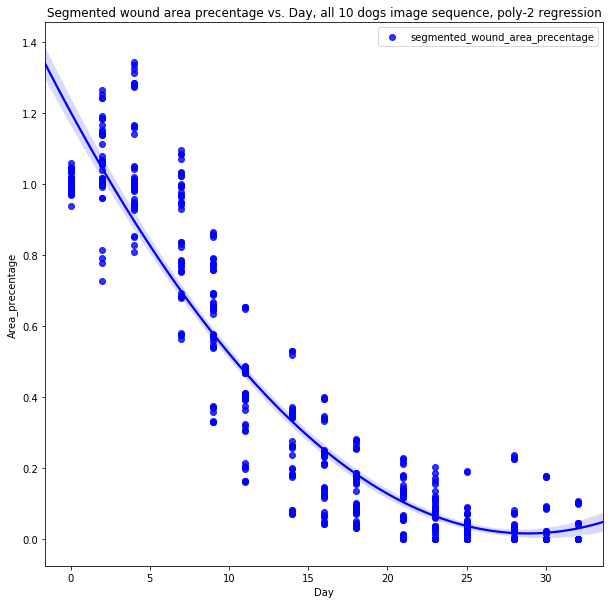

In [23]:
fig_path = './data/all_dog_wounds_noAugmentation/figures/'
fig_path = fig_path + pred_save_path

fig, ax = plt.subplots(figsize=(10,10))
# Plot the segmentation wound area change. 
# If order is greater than 1, use numpy.polyfit to estimate a polynomial regression.

sns.regplot(data=wound_area_df, x='Day', y='Area_precentage', order = 2,
            color='blue', label='segmented_wound_area_precentage', ax=ax)
ax.set(title='Segmented wound area precentage vs. Day, all 10 dogs image sequence, poly-2 regression')
ax.legend(loc='upper right')

#fig.savefig(fig_path + "Segmented wound area precentage vs. Day, all 10 dogs image sequence.png")

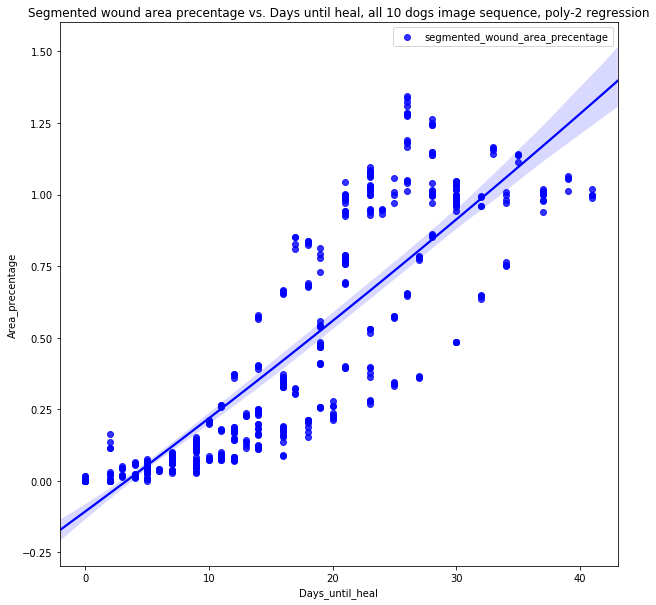

In [24]:
fig_path = './data/all_dog_wounds_noAugmentation/figures/'
fig_path = fig_path + pred_save_path

fig, ax = plt.subplots(figsize=(10,10))
# Plot the segmentation wound area change. 
# If order is greater than 1, use numpy.polyfit to estimate a polynomial regression.

sns.regplot(data=wound_area_df, x='Days_until_heal', y='Area_precentage', order = 2,
            color='blue', label='segmented_wound_area_precentage', ax=ax)
ax.set(title='Segmented wound area precentage vs. Days until heal, all 10 dogs image sequence, poly-2 regression')
ax.legend(loc='upper right')

#fig.savefig(fig_path + "Segmented wound area precentage vs. Days until heal, all 10 dogs image sequence.png")

## Separate training and test data set
1. Try use dog 9 and 10 as separate test image sequence
2. Try use the < 15 days image sequence as training input and > 15 days image sequence as test input (Tried, not working)


In [25]:
# manually set the random seed to define a replication
r_seed = 42

# manually set the number for cross validation
num_cv = 5

# manually set the test dog wound image sequences (9 or 10)
# [9, 10]
test_num = [9,10]

print("current random seed is: ", r_seed)
print("current test wound image sequence is: ", test_num)

current random seed is:  42
current test wound image sequence is:  [9, 10]


### Part 1
Train the GPR on the 1-8 dog wound image sequence

In [26]:
# 1. use dog 9 and 10 as separate test image sequences, use dog 1-8 as training image sequences
#    Notice: dog 2 is a good example of chronic wound
#    Train data need to drop the Dog_label column, but save the Area_mm2 and Area_precentage columns as features
# Train
X_train = feature_data[feature_data['Dog_label'].isin(range(1,9))]
X_train = X_train.drop(['Dog_label'], axis = 1)
X_train = X_train.drop(['Day'], axis = 1)
print("The training dataset's shape is: ", X_train.shape)

#X_test = feature_data[feature_data['Dog_label'].isin([test_num])]
X_test = feature_data[feature_data['Dog_label'].isin(test_num)]
X_test = X_test.drop(['Dog_label'], axis = 1)
X_test = X_test.drop(['Day'], axis = 1)
#print(X_test.shape)

# Label
Y_train = wound_area_df[wound_area_df['Dog_label'].isin(range(1,9))]
Y_train = Y_train['Days_until_heal']

#Y_test = wound_area_df[wound_area_df['Dog_label'].isin([test_num])]
Y_test = wound_area_df[wound_area_df['Dog_label'].isin(test_num)]
Y_test = Y_test['Days_until_heal']

#print(X_test)
#print(Y_test)

# the days vector
# 1. predict the dog 9 and 10 wound image sequences
#days_seq = wound_area_df[wound_area_df.Dog_label == test_num]['Day']
days_seq = wound_area_df[wound_area_df.Dog_label.isin(test_num)]['Day']
print("The test wound image sequence's days:\n", days_seq)

#Area_prop_seq = wound_area_df[wound_area_df.Dog_label == test_num]['Area_precentage']
Area_prop_seq = wound_area_df[wound_area_df.Dog_label.isin(test_num)]['Area_precentage']
print("The test wound image sequence's Area proportion:\n", Area_prop_seq)

The training dataset's shape is:  (440, 344)
The test wound image sequence's days:
 -09-CON-D00-R.png              0.0
-09-CON-D02-R.png              2.0
-09-CON-D04-R.png              4.0
-09-CON-D07-R.png              7.0
-09-CON-D09-R.png              9.0
-09-CON-D11-R.png             11.0
-09-CON-D14-R.png             14.0
-09-CON-D16-R.png             16.0
-09-CON-D18-R.png             18.0
-09-CON-D21-R.png             21.0
-09-CON-D23-R.png             23.0
-09-CON-D25-R.png             25.0
-09-CON-D28-R.png             28.0
-09-CON-D30-R.png             30.0
-10-CON-D00-R.png              0.0
-10-CON-D02-R.png              2.0
-10-CON-D04-R.png              4.0
-10-CON-D07-R.png              7.0
-10-CON-D09-R.png              9.0
-10-CON-D11-R.png             11.0
-10-CON-D14-R.png             14.0
-10-CON-D16-R.png             16.0
-10-CON-D18-R.png             18.0
-10-CON-D21-R.png             21.0
-10-CON-D23-R.png             23.0
-10-CON-D25-R.png             25.0
rotate

### Part 2
Train the GPR on all dog wound image sequences' (1 - 10) day 1-15 sequences.
Predict all all dog wound image sequences' (1 - 10) day 16-32 sequences.

In [27]:
# 2. use the < 16 days image sequence as training input and > 16 days image sequence as test input
# Train
#X_train = feature_data[feature_data['Day'].isin(range(0,16))]
#X_train = X_train.drop(['Dog_label','Area_mm2'], axis = 1)

#X_test = feature_data[feature_data['Day'].isin(range(16,35))]
#X_test = X_test[X_test['Dog_label'].isin([test_num])]

#X_test = feature_data[feature_data['Dog_label'].isin([test_num])]
#X_test = X_test.drop(['Dog_label','Area_mm2'], axis = 1)
# Label
#Y_train = wound_area_df[wound_area_df['Day'].isin(range(0,16))]
#Y_train = Y_train['Area_precentage']

#Y_test = wound_area_df[wound_area_df['Day'].isin(range(16, 35))]
#Y_test = Y_test[Y_test['Dog_label'].isin([test_num])]

#Y_test = wound_area_df[wound_area_df['Dog_label'].isin([test_num])]
#Y_test = Y_test['Area_precentage']

#print(X_test)
#print(Y_test)

# the days vector
# 1. predict the dog 9 or 10 wound image sequences
#days_seq = wound_area_df[wound_area_df.Dog_label == test_num]['Day']
#print("The test wound image sequence's days:\n", days_seq)

## Random Forest Regression
Define the RandomForestRegressor object.

### Random search for RF regressor

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 60)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 4, 6, 8, 10, 12, 13, 15, 17, 19, 21, 23, 25, 26, 28, 30, 32, 34, 36, 37, 39, 41, 43, 45, 47, 49, 50, 52, 54, 56, 58, 60, 61, 63, 65, 67, 69, 71, 73, 74, 76, 78, 80, 82, 84, 85, 87, 89, 91, 93, 95, 97, 98, 100, 102, 104, 106, 108, 110, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4, 6]}


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rs = RandomForestRegressor(random_state = r_seed)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rs_random = RandomizedSearchCV(estimator = rs, param_distributions = random_grid, n_iter = 200, cv = num_cv, verbose=2, random_state=r_seed, n_jobs = -1)
# Fit the random search model
rs_random.fit(X_train, Y_train)
print(rs_random.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] n_estimators=450, max_features=sqrt, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV] n_estimators=450, max_features=sqrt, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV] n_estimators=450, max_features=sqrt, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV] n_estimators=450, max_features=sqrt, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV] n_estimators=450, max_features=sqrt, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV] n_estimators=560, max_features=sqrt, max_depth=8, min_samples_split=5, bootstrap=False, min_samples_leaf=4 
[CV] n_estimators=560, max_features=sqrt, max_depth=8, min_samples_split=5, bootstrap=False, min_samples_leaf=4 
[CV] n_estimators=560, max_features=sqrt, max_depth=8, min_samples_split=5, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=450, max

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s


[CV]  n_estimators=450, max_features=sqrt, max_depth=91, min_samples_split=10, bootstrap=True, min_samples_leaf=4, total=   1.5s
[CV] n_estimators=450, max_features=auto, max_depth=87, min_samples_split=2, bootstrap=True, min_samples_leaf=1 
[CV]  n_estimators=450, max_features=sqrt, max_depth=91, min_samples_split=10, bootstrap=True, min_samples_leaf=4, total=   1.5s
[CV] n_estimators=890, max_features=auto, max_depth=58, min_samples_split=2, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=450, max_features=sqrt, max_depth=91, min_samples_split=10, bootstrap=True, min_samples_leaf=4, total=   1.6s
[CV] n_estimators=890, max_features=auto, max_depth=58, min_samples_split=2, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=450, max_features=sqrt, max_depth=91, min_samples_split=10, bootstrap=True, min_samples_leaf=4, total=   1.5s
[CV] n_estimators=890, max_features=auto, max_depth=58, min_samples_split=2, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=450, max_f

[CV]  n_estimators=10, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=10, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=10, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   0.1s
[CV]  n_estimators=10, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   0.1s
[CV] n_estimators=340, max_features=auto, max_depth=87, min_samples_split=10, bootstrap=True, min_samples_leaf=4 
[CV] n_estimators=340, max_features=auto, max_depth=87, min_samples_split=10, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=890, max_

[CV]  n_estimators=560, max_features=auto, max_depth=13, min_samples_split=2, bootstrap=True, min_samples_leaf=1, total=  22.4s
[CV] n_estimators=780, max_features=auto, max_depth=95, min_samples_split=10, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=1000, max_features=auto, max_depth=6, min_samples_split=5, bootstrap=True, min_samples_leaf=2, total=  33.1s
[CV] n_estimators=780, max_features=auto, max_depth=95, min_samples_split=10, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=1000, max_features=auto, max_depth=6, min_samples_split=5, bootstrap=True, min_samples_leaf=2, total=  33.2s
[CV] n_estimators=780, max_features=auto, max_depth=95, min_samples_split=10, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=1000, max_features=auto, max_depth=6, min_samples_split=5, bootstrap=True, min_samples_leaf=2, total=  33.3s
[CV] n_estimators=340, max_features=auto, max_depth=67, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=340, max_

[CV]  n_estimators=120, max_features=auto, max_depth=39, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=   4.6s
[CV] n_estimators=1000, max_features=auto, max_depth=49, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=120, max_features=auto, max_depth=39, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=   4.6s
[CV] n_estimators=1000, max_features=auto, max_depth=49, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=890, max_features=auto, max_depth=23, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  57.1s
[CV] n_estimators=1000, max_features=auto, max_depth=49, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=890, max_features=auto, max_depth=23, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  58.2s
[CV] n_estimators=1000, max_features=auto, max_depth=49, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=890

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min


[CV]  n_estimators=670, max_features=sqrt, max_depth=49, min_samples_split=2, bootstrap=True, min_samples_leaf=2, total=   2.5s
[CV] n_estimators=670, max_features=sqrt, max_depth=49, min_samples_split=2, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=670, max_features=sqrt, max_depth=49, min_samples_split=2, bootstrap=True, min_samples_leaf=2, total=   2.5s
[CV] n_estimators=10, max_features=sqrt, max_depth=98, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=98, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=98, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=98, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=98, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=

[CV]  n_estimators=120, max_features=sqrt, max_depth=28, min_samples_split=5, bootstrap=False, min_samples_leaf=4, total=   0.6s
[CV] n_estimators=780, max_features=auto, max_depth=21, min_samples_split=5, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=670, max_features=auto, max_depth=67, min_samples_split=10, bootstrap=True, min_samples_leaf=1, total=  22.9s
[CV] n_estimators=780, max_features=auto, max_depth=21, min_samples_split=5, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=670, max_features=auto, max_depth=67, min_samples_split=10, bootstrap=True, min_samples_leaf=1, total=  22.8s
[CV] n_estimators=120, max_features=auto, max_depth=84, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=670, max_features=auto, max_depth=67, min_samples_split=10, bootstrap=True, min_samples_leaf=1, total=  23.0s
[CV] n_estimators=120, max_features=auto, max_depth=84, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=670, max_

[CV]  n_estimators=560, max_features=sqrt, max_depth=23, min_samples_split=2, bootstrap=True, min_samples_leaf=1, total=   2.4s
[CV] n_estimators=1000, max_features=sqrt, max_depth=13, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=230, max_features=sqrt, max_depth=49, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=   1.3s
[CV] n_estimators=1000, max_features=sqrt, max_depth=13, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=230, max_features=sqrt, max_depth=49, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=   1.3s
[CV] n_estimators=1000, max_features=sqrt, max_depth=13, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=230, max_features=sqrt, max_depth=49, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=   1.3s
[CV] n_estimators=890, max_features=auto, max_depth=73, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=230, max_

[CV]  n_estimators=10, max_features=auto, max_depth=30, min_samples_split=10, bootstrap=True, min_samples_leaf=2, total=   0.3s
[CV] n_estimators=890, max_features=sqrt, max_depth=67, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=10, max_features=auto, max_depth=30, min_samples_split=10, bootstrap=True, min_samples_leaf=2, total=   0.3s
[CV] n_estimators=890, max_features=sqrt, max_depth=67, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=670, max_features=sqrt, max_depth=26, min_samples_split=5, bootstrap=True, min_samples_leaf=4, total=   2.3s
[CV] n_estimators=890, max_features=sqrt, max_depth=67, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=890, max_features=sqrt, max_depth=67, min_samples_split=5, bootstrap=True, min_samples_leaf=4, total=   3.1s
[CV] n_estimators=890, max_features=sqrt, max_depth=67, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=890, max_features

[CV]  n_estimators=560, max_features=sqrt, max_depth=80, min_samples_split=10, bootstrap=True, min_samples_leaf=6, total=   1.8s
[CV] n_estimators=340, max_features=sqrt, max_depth=78, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=340, max_features=sqrt, max_depth=78, min_samples_split=10, bootstrap=True, min_samples_leaf=2, total=   1.2s
[CV] n_estimators=340, max_features=sqrt, max_depth=78, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=560, max_features=sqrt, max_depth=80, min_samples_split=10, bootstrap=True, min_samples_leaf=6, total=   1.7s
[CV] n_estimators=340, max_features=sqrt, max_depth=78, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=560, max_features=sqrt, max_depth=80, min_samples_split=10, bootstrap=True, min_samples_leaf=6, total=   1.8s
[CV] n_estimators=340, max_features=sqrt, max_depth=78, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=340, max_

[CV]  n_estimators=780, max_features=sqrt, max_depth=71, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=   4.5s
[CV] n_estimators=560, max_features=sqrt, max_depth=67, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=780, max_features=sqrt, max_depth=71, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=   4.5s
[CV] n_estimators=1000, max_features=auto, max_depth=87, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=560, max_features=sqrt, max_depth=67, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   3.0s
[CV] n_estimators=1000, max_features=auto, max_depth=87, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=560, max_features=sqrt, max_depth=67, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   3.1s
[CV] n_estimators=1000, max_features=auto, max_depth=87, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=340

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.9min


[CV]  n_estimators=780, max_features=sqrt, max_depth=8, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   3.7s
[CV] n_estimators=230, max_features=auto, max_depth=97, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=780, max_features=sqrt, max_depth=8, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   3.7s
[CV] n_estimators=230, max_features=auto, max_depth=97, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=780, max_features=sqrt, max_depth=8, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   3.8s
[CV] n_estimators=230, max_features=auto, max_depth=97, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=780, max_features=sqrt, max_depth=8, min_samples_split=2, bootstrap=False, min_samples_leaf=4, total=   3.8s
[CV] n_estimators=1000, max_features=auto, max_depth=19, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=230, max_fe

[CV]  n_estimators=120, max_features=sqrt, max_depth=91, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=   0.7s
[CV] n_estimators=560, max_features=sqrt, max_depth=12, min_samples_split=10, bootstrap=True, min_samples_leaf=1 
[CV]  n_estimators=560, max_features=sqrt, max_depth=12, min_samples_split=10, bootstrap=True, min_samples_leaf=1, total=   2.0s
[CV] n_estimators=560, max_features=sqrt, max_depth=12, min_samples_split=10, bootstrap=True, min_samples_leaf=1 
[CV]  n_estimators=560, max_features=sqrt, max_depth=12, min_samples_split=10, bootstrap=True, min_samples_leaf=1, total=   2.0s
[CV] n_estimators=560, max_features=sqrt, max_depth=12, min_samples_split=10, bootstrap=True, min_samples_leaf=1 
[CV]  n_estimators=230, max_features=auto, max_depth=25, min_samples_split=2, bootstrap=True, min_samples_leaf=2, total=   8.4s
[CV] n_estimators=560, max_features=sqrt, max_depth=12, min_samples_split=10, bootstrap=True, min_samples_leaf=1 
[CV]  n_estimators=560, max_f

[CV]  n_estimators=560, max_features=auto, max_depth=84, min_samples_split=2, bootstrap=True, min_samples_leaf=1, total=  22.0s
[CV] n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=   2.5s
[CV] n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=   2.5s
[CV] n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=   2.5s
[CV] n_estimators=780, max_features=sqrt, max_depth=102, min_samples_split=2, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=780, max_f

[CV]  n_estimators=230, max_features=auto, max_depth=74, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=   6.6s
[CV] n_estimators=560, max_features=sqrt, max_depth=43, min_samples_split=2, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=560, max_features=sqrt, max_depth=43, min_samples_split=2, bootstrap=True, min_samples_leaf=2, total=   2.2s
[CV]  n_estimators=560, max_features=sqrt, max_depth=43, min_samples_split=2, bootstrap=True, min_samples_leaf=2, total=   2.1s
[CV] n_estimators=120, max_features=sqrt, max_depth=1, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV] n_estimators=120, max_features=sqrt, max_depth=1, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=120, max_features=sqrt, max_depth=1, min_samples_split=5, bootstrap=True, min_samples_leaf=2, total=   0.2s
[CV] n_estimators=120, max_features=sqrt, max_depth=1, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=120, max_features=sqr

[CV]  n_estimators=450, max_features=auto, max_depth=89, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=  17.2s
[CV] n_estimators=1000, max_features=sqrt, max_depth=58, min_samples_split=2, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=450, max_features=auto, max_depth=89, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=  17.3s
[CV] n_estimators=1000, max_features=sqrt, max_depth=58, min_samples_split=2, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=1000, max_features=sqrt, max_depth=58, min_samples_split=2, bootstrap=True, min_samples_leaf=4, total=   3.3s
[CV] n_estimators=450, max_features=auto, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=1000, max_features=sqrt, max_depth=58, min_samples_split=2, bootstrap=True, min_samples_leaf=4, total=   3.4s
[CV] n_estimators=450, max_features=auto, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=1000, m

[CV]  n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4, total=   3.8s
[CV] n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4, total=   3.8s
[CV] n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4, total=   3.8s
[CV] n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=780, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=4, total=   3.8s
[CV] n_estimators=10, max_features=auto, max_depth=74, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=10,

[CV]  n_estimators=560, max_features=sqrt, max_depth=93, min_samples_split=2, bootstrap=True, min_samples_leaf=4, total=   2.0s
[CV] n_estimators=340, max_features=sqrt, max_depth=50, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=560, max_features=sqrt, max_depth=93, min_samples_split=2, bootstrap=True, min_samples_leaf=4, total=   1.9s
[CV] n_estimators=340, max_features=sqrt, max_depth=50, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=340, max_features=sqrt, max_depth=50, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total=   2.1s
[CV] n_estimators=340, max_features=sqrt, max_depth=50, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=340, max_features=sqrt, max_depth=50, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total=   2.1s
[CV] n_estimators=340, max_features=sqrt, max_depth=50, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=340, max_fe

[CV]  n_estimators=890, max_features=auto, max_depth=80, min_samples_split=5, bootstrap=False, min_samples_leaf=6, total=  47.5s
[CV] n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=106, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10

[CV]  n_estimators=780, max_features=auto, max_depth=15, min_samples_split=5, bootstrap=True, min_samples_leaf=6, total=  22.0s
[CV] n_estimators=780, max_features=auto, max_depth=15, min_samples_split=5, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=780, max_features=auto, max_depth=15, min_samples_split=5, bootstrap=True, min_samples_leaf=6, total=  22.1s
[CV] n_estimators=560, max_features=auto, max_depth=21, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=560, max_features=auto, max_depth=21, min_samples_split=10, bootstrap=True, min_samples_leaf=2, total=  18.9s
[CV] n_estimators=560, max_features=auto, max_depth=21, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=780, max_features=auto, max_depth=15, min_samples_split=5, bootstrap=True, min_samples_leaf=6, total=  22.3s
[CV] n_estimators=560, max_features=auto, max_depth=21, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=780, max_feat

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 16.9min


[CV]  n_estimators=120, max_features=sqrt, max_depth=87, min_samples_split=2, bootstrap=False, min_samples_leaf=2, total=   0.7s
[CV] n_estimators=230, max_features=auto, max_depth=6, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=120, max_features=sqrt, max_depth=87, min_samples_split=2, bootstrap=False, min_samples_leaf=2, total=   0.7s
[CV] n_estimators=230, max_features=auto, max_depth=6, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=780, max_features=auto, max_depth=56, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total=  54.1s
[CV] n_estimators=230, max_features=auto, max_depth=6, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=780, max_features=auto, max_depth=56, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total=  54.3s
[CV] n_estimators=230, max_features=auto, max_depth=6, min_samples_split=2, bootstrap=False, min_samples_leaf=4 
[CV]  n_estimators=560, max_feat

[CV]  n_estimators=670, max_features=auto, max_depth=52, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=  25.7s
[CV] n_estimators=10, max_features=auto, max_depth=None, min_samples_split=10, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=10, max_features=auto, max_depth=None, min_samples_split=10, bootstrap=False, min_samples_leaf=2, total=   0.6s
[CV] n_estimators=670, max_features=sqrt, max_depth=97, min_samples_split=2, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=670, max_features=auto, max_depth=52, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=  25.6s
[CV] n_estimators=670, max_features=sqrt, max_depth=97, min_samples_split=2, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=10, max_features=auto, max_depth=None, min_samples_split=10, bootstrap=False, min_samples_leaf=2, total=   0.6s
[CV] n_estimators=670, max_features=sqrt, max_depth=97, min_samples_split=2, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=10, max_

[CV]  n_estimators=230, max_features=auto, max_depth=61, min_samples_split=5, bootstrap=False, min_samples_leaf=6, total=  12.3s
[CV] n_estimators=230, max_features=auto, max_depth=61, min_samples_split=5, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=340, max_features=auto, max_depth=37, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  22.3s
[CV] n_estimators=230, max_features=auto, max_depth=61, min_samples_split=5, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=340, max_features=auto, max_depth=37, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  22.5s
[CV] n_estimators=230, max_features=sqrt, max_depth=63, min_samples_split=10, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=340, max_features=auto, max_depth=37, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  21.7s
[CV] n_estimators=230, max_features=sqrt, max_depth=63, min_samples_split=10, bootstrap=True, min_samples_leaf=6 
[CV]  n_estimators=230, max_

[CV]  n_estimators=890, max_features=auto, max_depth=37, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  58.9s
[CV] n_estimators=450, max_features=auto, max_depth=19, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=450, max_features=sqrt, max_depth=None, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=   2.6s
[CV] n_estimators=450, max_features=auto, max_depth=19, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=1000, max_features=auto, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=4, total=  58.9s
[CV] n_estimators=450, max_features=auto, max_depth=19, min_samples_split=10, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=1000, max_features=auto, max_depth=69, min_samples_split=5, bootstrap=False, min_samples_leaf=4, total=  59.2s
[CV] n_estimators=780, max_features=auto, max_depth=91, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=450, m

[CV]  n_estimators=1000, max_features=auto, max_depth=108, min_samples_split=10, bootstrap=True, min_samples_leaf=6, total=  28.7s
[CV] n_estimators=230, max_features=sqrt, max_depth=74, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=230, max_features=sqrt, max_depth=74, min_samples_split=5, bootstrap=True, min_samples_leaf=2, total=   0.8s
[CV] n_estimators=230, max_features=sqrt, max_depth=74, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=230, max_features=sqrt, max_depth=74, min_samples_split=5, bootstrap=True, min_samples_leaf=2, total=   0.9s
[CV] n_estimators=230, max_features=sqrt, max_depth=74, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=1000, max_features=auto, max_depth=108, min_samples_split=10, bootstrap=True, min_samples_leaf=6, total=  28.6s
[CV] n_estimators=230, max_features=sqrt, max_depth=74, min_samples_split=5, bootstrap=True, min_samples_leaf=2 
[CV]  n_estimators=230, max_fe

[CV]  n_estimators=340, max_features=auto, max_depth=106, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=  10.1s
[CV] n_estimators=230, max_features=sqrt, max_depth=21, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=340, max_features=auto, max_depth=106, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=   9.8s
[CV] n_estimators=230, max_features=sqrt, max_depth=21, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=340, max_features=auto, max_depth=106, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=   9.6s
[CV] n_estimators=230, max_features=sqrt, max_depth=21, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=230, max_features=sqrt, max_depth=21, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=   1.3s
[CV] n_estimators=230, max_features=sqrt, max_depth=21, min_samples_split=5, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=230, max_

[CV]  n_estimators=230, max_features=auto, max_depth=67, min_samples_split=5, bootstrap=False, min_samples_leaf=2, total=  15.0s
[CV] n_estimators=230, max_features=auto, max_depth=67, min_samples_split=5, bootstrap=False, min_samples_leaf=2 
[CV]  n_estimators=1000, max_features=auto, max_depth=71, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total= 1.1min
[CV] n_estimators=230, max_features=sqrt, max_depth=47, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=1000, max_features=auto, max_depth=71, min_samples_split=2, bootstrap=False, min_samples_leaf=1, total= 1.2min
[CV] n_estimators=230, max_features=sqrt, max_depth=47, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=230, max_features=sqrt, max_depth=47, min_samples_split=10, bootstrap=False, min_samples_leaf=6, total=   1.0s
[CV] n_estimators=230, max_features=sqrt, max_depth=47, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=230

[CV]  n_estimators=560, max_features=auto, max_depth=73, min_samples_split=5, bootstrap=False, min_samples_leaf=6, total=  30.0s
[CV] n_estimators=890, max_features=auto, max_depth=25, min_samples_split=5, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=560, max_features=auto, max_depth=73, min_samples_split=5, bootstrap=False, min_samples_leaf=6, total=  29.4s
[CV] n_estimators=890, max_features=auto, max_depth=25, min_samples_split=5, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=560, max_features=auto, max_depth=73, min_samples_split=5, bootstrap=False, min_samples_leaf=6, total=  30.0s
[CV] n_estimators=230, max_features=auto, max_depth=74, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=560, max_features=auto, max_depth=73, min_samples_split=5, bootstrap=False, min_samples_leaf=6, total=  29.4s
[CV] n_estimators=230, max_features=auto, max_depth=74, min_samples_split=2, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=560, max_

[CV]  n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1 
[CV]  n_estimators=10, max_features=sqrt, max_depth=52, min_samples_split=10, bootstrap=False, min_samples_leaf=1, total=   0.1s
[CV] n_estimators=340, max_features=sqrt, max_depth=95, min_samples_split=10, bootstrap=True, min_samples_leaf=1 
[CV]  n_estimators=10, max_f

[CV]  n_estimators=450, max_features=sqrt, max_depth=49, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=   1.8s
[CV] n_estimators=670, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=450, max_features=sqrt, max_depth=49, min_samples_split=5, bootstrap=True, min_samples_leaf=1, total=   1.8s
[CV] n_estimators=670, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=670, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=6, total=   3.2s
[CV] n_estimators=670, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=340, max_features=auto, max_depth=60, min_samples_split=10, bootstrap=False, min_samples_leaf=4, total=  19.8s
[CV] n_estimators=670, max_features=sqrt, max_depth=65, min_samples_split=10, bootstrap=False, min_samples_leaf=6 
[CV]  n_estimators=670, 

[CV]  n_estimators=1000, max_features=auto, max_depth=8, min_samples_split=2, bootstrap=True, min_samples_leaf=6, total=  28.7s
[CV] n_estimators=450, max_features=auto, max_depth=76, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=230, max_features=auto, max_depth=65, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=  15.4s
[CV] n_estimators=450, max_features=auto, max_depth=76, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=230, max_features=auto, max_depth=65, min_samples_split=5, bootstrap=False, min_samples_leaf=1, total=  15.6s
[CV] n_estimators=450, max_features=auto, max_depth=76, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=450, max_features=auto, max_depth=76, min_samples_split=5, bootstrap=True, min_samples_leaf=4, total=  14.5s
[CV] n_estimators=450, max_features=auto, max_depth=76, min_samples_split=5, bootstrap=True, min_samples_leaf=4 
[CV]  n_estimators=450, max_featur

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 26.8min finished


{'n_estimators': 450, 'max_features': 'auto', 'max_depth': 19, 'min_samples_split': 10, 'bootstrap': True, 'min_samples_leaf': 2}


### Grid search for RF regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(400, 500, 5)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [18,19,20]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [9,10,11]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gp = RandomForestRegressor(random_state = r_seed)

# print parameters
print(gp.get_params())

# scores for regression
#
#Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 
#'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 
#'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 
#'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 
#'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 
#'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 
#'roc_auc', 'v_measure_score']

grid_gp = GridSearchCV(estimator = gp, cv=num_cv, param_grid=param_grid, n_jobs=-1, scoring = 'r2', verbose=10)
grid_gp.fit(X_train, Y_train)

print(grid_gp.best_params_)
gp = grid_gp.best_estimator_

print("The CV results are: ", grid_gp.best_score_)

# Make the prediction on test set.
Y_pred = gp.predict(X_test)
#print(Y_pred)

{'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_jobs': 1, 'max_depth': None, 'min_samples_split': 2, 'min_impurity_split': None, 'criterion': 'mse', 'oob_score': False, 'min_samples_leaf': 1, 'n_estimators': 10, 'random_state': 42, 'warm_start': False, 'max_leaf_nodes': None, 'max_features': 'auto', 'verbose': 0, 'min_weight_fraction_leaf': 0.0}
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV] bootstrap=Tru

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.6s


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=2, score=0.9174174114255382, total=  13.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2, score=0.9240279821578562, total=  13.8s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=2, score=0.9234299930442758, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=2, score=0.9023649798383355, total=  13.7s
[CV]  bootstrap=True, max_depth=18, max_featu

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.3s


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=2, score=0.9237194162921163, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=2, score=0.9175473797020592, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=2, score=0.9239838640681912, total=  14.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=2, score=0.9031753503631542, total=  14.1s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   28.2s


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9029742915357765, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9175624315722569, total=  14.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9024155163748244, total=  14.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9238996540976201, total=  14.3s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.8s


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2, score=0.9237968562240102, total=  14.5s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2, score=0.9175087769854416, total=  14.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2, score=0.9029887041530635, total=  14.5s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2, score=0.9239703989022856, total=  14.5s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.9025283510518797, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9172780562481401, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9238582267074827, total=  14.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9028426031297307, total=  14.7s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9031536921999561, total=  15.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9170827127305574, total=  15.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9241987271188886, total=  15.2s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9022508515940453, total=  15.1s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.7min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2, score=0.9031259134439893, total=  15.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2, score=0.9168376424920204, total=  15.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2, score=0.9242774848274947, total=  15.5s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2, score=0.9024739098524666, total=  15.5s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.2min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9023254012016777, total=  16.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2, score=0.9237373444234775, total=  16.2s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2, score=0.9036088779929887, total=  15.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2, score=0.9165345352027314, total=  15.8s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.7min


[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=2, score=0.9236078711221383, total=  16.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=2, score=0.9021134096736144, total=  16.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2, score=0.9238004242334203, total=  16.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_s

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.3min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=2, score=0.9036385251164221, total=  13.3s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=2, score=0.9175447475477869, total=  13.3s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=2, score=0.9038882095618695, total=  16.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=2, score=0.9167662813520631, total=  16.8s
[CV] bootstrap=True, max_depth=18, max_f

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.5min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=2, score=0.9177517213055695, total=  13.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=2, score=0.924282285308056, total=  13.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=2, score=0.9021224961277462, total=  13.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2, score=0.9037425527236159, total=  13.7s
[CV] bootstrap=True, max_depth=18, max_

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.2min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=2, score=0.9022999996881225, total=  14.2s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=2, score=0.9232987372277401, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=2, score=0.9037313239982535, total=  14.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=2, score=0.9175068643939328, total=  14.4s
[CV] bootstrap=True, max_depth=18, max

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.7min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9040349342593366, total=  14.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9173125983562379, total=  14.8s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9244652500744698, total=  14.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9019094631753575, total=  14.9s
[CV] bootstrap=True, max_depth=18, max

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  5.2min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.923392937381605, total=  15.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.904263442083054, total=  15.3s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9169756443420718, total=  15.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9242687716736402, total=  15.5s
[CV] bootstrap=True, max_depth=18, max_f

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.8min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=2, score=0.9016907164707023, total=  16.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9234714636437162, total=  16.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9166268357651401, total=  16.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9046631475009322, total=  16.2s
[CV] bootstrap=True, max_depth=18, max

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  6.5min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2, score=0.9227263854875798, total=  13.2s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2, score=0.9038111042208905, total=  13.2s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2, score=0.9178677234170763, total=  13.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2, score=0.9243873214132664, total=  13.4s
[CV] bootstrap=True, max_depth=18, max

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  7.2min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.903994627343094, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.9179479245501331, total=  13.8s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.9241808882409126, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.9028916650101174, total=  14.0s
[CV] bootstrap=True, max_depth=18, max_

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  7.9min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=11, min_samples_leaf=2, score=0.9024330096428861, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=11, min_samples_leaf=2, score=0.9232388065816697, total=  14.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=11, min_samples_leaf=2, score=0.9042136404177065, total=  14.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=11, min_samples_leaf=2, score=0.9174829186177363, total=  14.7s
[CV] bootstrap=True, max_depth=18, max

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  8.5min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2, score=0.9169693996909442, total=  15.5s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2, score=0.9240142759869163, total=  15.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2, score=0.9022010405855031, total=  15.3s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=2, score=0.923373001446253, total=  15.7s
[CV] bootstrap=True, max_depth=18, max_

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  9.4min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9172571187042535, total=  16.3s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3, score=0.9230885552672567, total=  13.3s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9235938974658634, total=  16.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3, score=0.9030839812927127, total=  13.0s
[CV] bootstrap=True, max_depth=18, max_feat

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 10.1min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=3, score=0.9179744063785515, total=  13.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=3, score=0.9020208563518121, total=  13.8s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=3, score=0.923481326429812, total=  14.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=3, score=0.9234024458261608, total=  14.0s
[CV] bootstrap=True, max_depth=18, max_feature

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.9min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=3, score=0.9017726562260133, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9236273419860723, total=  15.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9030695690892016, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9173779988914169, total=  14.7s
[CV] bootstrap=True, max_depth=18, max_featur

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 11.7min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=3, score=0.9037639394317258, total=  15.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=3, score=0.916984115165843, total=  15.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=3, score=0.9235515046215561, total=  15.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=3, score=0.9014241586932, total=  15.7s
[CV] bootstrap=True, max_depth=18, max_features=a

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 12.7min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3, score=0.9230972615253386, total=  13.2s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3, score=0.9029603854685514, total=  13.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3, score=0.9173619287150359, total=  13.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3, score=0.9245035635722215, total=  13.2s
[CV] bootstrap=True, max_depth=18, max

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.5min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3, score=0.9235567470873918, total=  14.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3, score=0.902927752508355, total=  14.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3, score=0.9172804188847187, total=  14.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3, score=0.9240985120218831, total=  14.5s
[CV] bootstrap=True, max_depth=18, max_

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 14.5min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.9235343249459037, total=  15.1s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.9032879105109956, total=  15.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.9167300840302439, total=  15.0s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.924122869171662, total=  15.3s
[CV] bootstrap=True, max_depth=18, max_

[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 15.4min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9039220398432287, total=  15.8s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9167921576187394, total=  15.8s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3, score=0.9227414530747526, total=  12.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9235602874541275, total=  16.2s
[CV] bootstrap=True, max_depth=18, max

[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9182441632520029, total=  13.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9242061444088006, total=  13.5s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 16.4min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9029599028389316, total=  13.4s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3, score=0.923271468047744, total=  13.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3, score=0.9035056422037062, total=  13.8s
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3, score=0.9180285141414845, total=  13.7s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=3 
[CV] bootstrap=True, max_depth=18, max_

[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3, score=0.9235839835984061, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3, score=0.9037362630467742, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 


[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 17.4min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3, score=0.9174215360450373, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3, score=0.9023892615037944, total=  14.6s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3, score=0.924290851376162, total=  14.9s
[CV] bootstrap=True, max_depth=18, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.9235123957910801, total=  15.0s
[CV] bootstrap=True, max_depth=18, max_

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3, score=0.9237081102729016, total=  15.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3, score=0.902052469169575, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3, score=0.9236553472860698, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 18.5min


[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3, score=0.9173116541650354, total=  15.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3, score=0.923679009872074, total=  15.9s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=18, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3, score=0.9019534308570187, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=2, score=0.9231993257660525, total=  13.6s
[CV] bootstrap=True, max_depth=19, max_feat

[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2, score=0.9239703989022856, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2, score=0.9027620941715694, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.9238008985960744, total=  14.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.902865475156326, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_feature

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 19.5min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.9172254087254632, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.923945302551636, total=  14.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.9025283510518797, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9238582267074827, total=  14.9s
[CV] bootstrap=True, max_depth=19, max_feature

[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=2, score=0.9240302753119719, total=  15.7s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=2, score=0.902256382851197, total=  15.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9238301334652504, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9033679185644841, total=  15.7s
[CV] bootstrap=True, max_depth=19, max_feature

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 20.7min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9023254012016777, total=  16.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2, score=0.9237373444234775, total=  16.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2, score=0.9036088779929887, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2, score=0.9165345352027314, total=  15.9s
[CV] bootstrap=True, max_depth=19, max_featur

[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=2, score=0.9036385251164221, total=  13.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=2, score=0.9020506466119469, total=  16.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=2, score=0.9175447475477869, total=  13.2s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=2, score=0.9244434243232643, total=  13.4s
[CV] bootstrap=True, max_depth=19, max_

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 21.9min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.9036545125108054, total=  13.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.9175910298566667, total=  13.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.9245270467134221, total=  13.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.902079693577307, total=  13.5s
[CV] bootstrap=True, max_depth=19, max_

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.917584703223927, total=  14.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9241624030735711, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9019563057618968, total=  14.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_sam

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 23.1min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.923342458381103, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9040349342593366, total=  14.9s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9173125983562379, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=455, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2, score=0.9244652500744698, total=  14.9s
[CV] bootstrap=True, max_depth=19, max_

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2, score=0.9046131821633943, total=  15.7s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2, score=0.9168151167410228, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2, score=0.9238998602143736, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_sa

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 24.3min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=2, score=0.9016907164707023, total=  16.1s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9234714636437162, total=  16.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9046631475009322, total=  16.1s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9166268357651401, total=  16.2s
[CV] bootstrap=True, max_depth=19, max

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=11, min_samples_leaf=2, score=0.9229118832038803, total=  13.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=11, min_samples_leaf=2, score=0.9039032708191499, total=  13.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=11, min_samples_leaf=2, score=0.9178847170421507, total=  13.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_sa

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 25.6min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.9230060549696224, total=  14.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.903994627343094, total=  14.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.9179479245501331, total=  13.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2, score=0.9241808882409126, total=  14.1s
[CV] bootstrap=True, max_depth=19, max_

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=2, score=0.9042101515111056, total=  15.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=2, score=0.9173623221291591, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=2, score=0.9025769094470606, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=455, min_sa

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 26.8min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2, score=0.9043932370183814, total=  15.2s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2, score=0.9171014612813205, total=  15.1s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2, score=0.9240511211537311, total=  15.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2, score=0.9024073361295204, total=  15.2s
[CV] bootstrap=True, max_depth=19, max

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9172571187042535, total=  16.1s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3, score=0.9230885552672567, total=  13.1s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9235938974658634, total=  16.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 28.2min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3, score=0.9018109584958209, total=  13.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=3, score=0.9233830008291146, total=  13.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=3, score=0.9034905099754814, total=  13.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=410, min_samples_split=9, min_samples_leaf=3, score=0.9178893364610061, total=  13.4s
[CV] bootstrap=True, max_depth=19, max_featur

[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=3, score=0.9237040502373681, total=  14.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=3, score=0.903108184639073, total=  14.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=3, score=0.9173451638778873, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=3, score=0.9238728974426046, total=  14.5s
[CV] bootstrap=True, max_depth=19, max_feature

[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 29.5min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9173779988914169, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9238764991763913, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9019187180953528, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3, score=0.9236823006426182, total=  15.1s
[CV] bootstrap=True, max_depth=19, max_featur

[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=3, score=0.923425230272052, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=3, score=0.9013720700988641, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=3, score=0.9237191757133574, total=  16.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=3, score=0.9038691372180003, total=  15.8s
[CV] bootstrap=True, max_depth=19, max_feature

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 30.9min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=3, score=0.9171771804733946, total=  16.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=3, score=0.923356541924671, total=  16.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=3, score=0.9229326214039485, total=  13.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=3, score=0.9012118976966823, total=  16.2s
[CV] bootstrap=True, max_depth=19, max_fea

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=3, score=0.924239907102341, total=  13.9s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=3, score=0.9029563002671153, total=  13.7s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3, score=0.9234322722833057, total=  14.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_sam

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed: 32.2min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3, score=0.9169368555143887, total=  14.1s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3, score=0.9243701938226608, total=  14.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3, score=0.9025887996818622, total=  14.2s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=3, score=0.9235158498305381, total=  14.6s
[CV] bootstrap=True, max_depth=19, max

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=3, score=0.9240326225513228, total=  15.2s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=3, score=0.9021392334334187, total=  15.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=3, score=0.9238000102253037, total=  15.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=480, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_sa

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed: 33.7min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=3, score=0.9018733815960127, total=  15.6s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9236302856678402, total=  15.9s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9039531933917385, total=  15.7s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9166293464600016, total=  15.8s
[CV] bootstrap=True, max_depth=19, max

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=3, score=0.9230745685340905, total=  13.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=3, score=0.9035048798373774, total=  13.2s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=3, score=0.9183082958154508, total=  13.4s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=420, min_sa

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 35.0min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3, score=0.903482146457401, total=  13.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3, score=0.9180620781874622, total=  13.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3, score=0.9240737488180973, total=  14.0s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=445, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3, score=0.9025496138569907, total=  13.8s
[CV] bootstrap=True, max_depth=19, max_

[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.917250193758689, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.92423110390584, total=  14.9s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.9023985214265691, total=  14.8s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=470, min_sampl

[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 36.5min


[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9237059359811671, total=  15.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9042572728527345, total=  15.5s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9169212768106269, total=  15.3s
[CV] bootstrap=True, max_depth=19, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=19, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9237865940769538, total=  15.6s
[CV] bootstrap=True, max_depth=19, max

[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9029742915357765, total=  14.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9175624315722569, total=  14.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9238996540976201, total=  14.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9024155163748244, total=  14.0s
[CV] bootstrap=True, max_depth=20, max_featur

[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 38.0min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=2, score=0.9025283510518797, total=  14.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9238582267074827, total=  15.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9028426031297307, total=  14.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=2, score=0.9172780562481401, total=  14.7s
[CV] bootstrap=True, max_depth=20, max_featur

[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9238301334652504, total=  15.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9033679185644841, total=  15.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9166853954899907, total=  15.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=2, score=0.9240152982794476, total=  15.8s
[CV] bootstrap=True, max_depth=20, max_featur

[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed: 39.7min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2, score=0.9238004242334203, total=  16.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2, score=0.9038825894274071, total=  16.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2, score=0.9163396082667158, total=  16.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2, score=0.9236393549691665, total=  16.5s
[CV] bootstrap=True, max_depth=20, max_featur

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2, score=0.9037425527236159, total=  13.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2, score=0.9177728130104511, total=  13.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2, score=0.9242580188598527, total=  13.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_sa

[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 41.2min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9037263162977307, total=  14.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.917584703223927, total=  14.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9241624030735711, total=  14.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9019563057618968, total=  14.7s
[CV] bootstrap=True, max_depth=20, max_

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9169756443420718, total=  15.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9242687716736402, total=  15.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9020144013203042, total=  15.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_sa

[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed: 43.0min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=10, min_samples_leaf=2, score=0.9015545739453694, total=  16.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2, score=0.9234718257097098, total=  16.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2, score=0.9048015895006901, total=  16.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=2, score=0.9168439871614679, total=  16.3s
[CV] bootstrap=True, max_depth=20, max

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=2, score=0.9229255685563528, total=  13.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=2, score=0.9037540909105357, total=  13.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=11, min_samples_leaf=2, score=0.9179816991327459, total=  13.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_sa

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 44.5min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=2, score=0.9174348766959641, total=  14.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=2, score=0.9243184884397736, total=  14.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=2, score=0.9025577907323924, total=  14.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=445, min_samples_split=11, min_samples_leaf=2, score=0.9231112077677962, total=  14.6s
[CV] bootstrap=True, max_depth=20, max

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2, score=0.9240142759869163, total=  15.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2, score=0.9022010405855031, total=  15.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=2, score=0.923373001446253, total=  15.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_sam

[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed: 46.3min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3, score=0.9230885552672567, total=  13.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9235938974658634, total=  16.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9020336466680126, total=  16.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3, score=0.9030839812927127, total=  13.0s
[CV] bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=3, score=0.9236836830444602, total=  14.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3, score=0.9235061542762207, total=  14.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3, score=0.9030909912392906, total=  14.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3, score=0.9176369378438426, total=  14.0s
[CV] bootstrap=True, max_depth=20, max_featur

[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 47.9min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9173779988914169, total=  14.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9238764991763913, total=  15.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=3, score=0.9019187180953528, total=  14.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3, score=0.9031491892661964, total=  14.8s
[CV] bootstrap=True, max_depth=20, max_featur

[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=3, score=0.923425230272052, total=  16.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=3, score=0.9013720700988641, total=  15.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=3, score=0.9237191757133574, total=  16.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=3, score=0.9038691372180003, total=  15.9s
[CV] bootstrap=True, max_depth=20, max_feature

[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed: 49.7min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=3, score=0.92333759650661, total=  13.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=3, score=0.9032846595706315, total=  13.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=3, score=0.9174772451037512, total=  13.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=3, score=0.9243007560886451, total=  13.3s
[CV] bootstrap=True, max_depth=20, max_f

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3, score=0.9029614786454208, total=  14.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3, score=0.9169368555143887, total=  14.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=3, score=0.9243701938226608, total=  14.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=450, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=440, min_sa

[Parallel(n_jobs=-1)]: Done 1666 tasks      | elapsed: 51.4min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.9032879105109956, total=  14.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.9167300840302439, total=  15.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.924122869171662, total=  15.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3, score=0.9023375842480001, total=  15.1s
[CV] bootstrap=True, max_depth=20, max_

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9167921576187394, total=  15.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3, score=0.9227414530747526, total=  12.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9235602874541275, total=  16.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=400, min_sa

[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed: 53.2min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9231742520697406, total=  13.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9036144165770706, total=  13.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9182441632520029, total=  13.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9029599028389316, total=  13.5s
[CV] bootstrap=True, max_depth=20, max

[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=3, score=0.9035804721093124, total=  14.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=3, score=0.9175290062174621, total=  14.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=3, score=0.9245096482499086, total=  14.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=455, min_sa

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 55.0min


[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=480, min_samples_split=11, min_samples_leaf=3, score=0.9020126565339768, total=  15.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9237059359811671, total=  15.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9042572728527345, total=  15.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=20, max_features=auto, n_estimators=485, min_samples_split=11, min_samples_leaf=3, score=0.9169212768106269, total=  15.5s
[CV] bootstrap=True, max_depth=20, max

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9237879555421493, total=  14.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9029742915357765, total=  13.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=420, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=415, min_samples_split=9, min_samples_leaf=2, score=0.9175624315722569, total=  14.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=41

[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed: 56.9min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9237906724764307, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9031536921999561, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=450, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9170827127305574, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=9, min_samples_leaf=2, score=0.9241987271188886, total=  15.3s
[CV] bootstrap=True, max_depth=

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2, score=0.9038744761952452, total=  16.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=480, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2, score=0.916565496941906, total=  16.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=9, min_samples_leaf=2, score=0.9237536848910923, total=  16.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=485, min_samples_split=9, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=475

[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed: 58.8min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.9036545125108054, total=  13.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=410, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.9175910298566667, total=  13.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.9245270467134221, total=  13.5s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=415, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=10, min_samples_leaf=2, score=0.902079693577307, total=  13.5s
[CV] bootstrap=True, max_

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=440, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.917584703223927, total=  14.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9241624030735711, total=  14.5s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=2, score=0.9019563057618968, total=  14.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=445, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimat

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9169756443420718, total=  15.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9242687716736402, total=  15.8s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 


[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 60.7min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=2, score=0.9020144013203042, total=  15.6s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=2, score=0.9233382418798628, total=  15.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=2, score=0.9044152154794912, total=  15.5s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=10, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=2, score=0.916849742950334, total=  15.6s
[CV] bootstrap=True, max_

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=2, score=0.9038344664963587, total=  13.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=2, score=0.9015986700873236, total=  16.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=2, score=0.9178395069206454, total=  13.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=410, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estima

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2, score=0.9230532180949522, total=  14.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2, score=0.9040109324401518, total=  14.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=2 


[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 62.7min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2, score=0.9177528050137443, total=  14.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2, score=0.9241406679441669, total=  14.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=2, score=0.9027129445624871, total=  14.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=440, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=2, score=0.9231609941091392, total=  14.3s
[CV] bootstrap=True, max

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=2, score=0.9241202397307143, total=  15.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=2, score=0.9023309153699648, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=2, score=0.9231988527945181, total=  15.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=2 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estima

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=2, score=0.9235824638564255, total=  16.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=11, min_samples_leaf=2, score=0.9020522167399112, total=  16.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.923309956289181, total=  16.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9048191389116631, total=  16.3s
[CV] bootstrap=True, max_dep

[Parallel(n_jobs=-1)]: Done 2097 tasks      | elapsed: 64.8min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9172571187042535, total=  16.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=9, min_samples_leaf=3, score=0.9230885552672567, total=  13.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9235938974658634, total=  16.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=2, score=0.9020336466680126, total=  16.2s
[CV] bootstrap=True, max_dep

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=3, score=0.9236836830444602, total=  14.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=9, min_samples_leaf=3, score=0.902211827161796, total=  14.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=9, min_samples_leaf=3, score=0.9235061542762207, total=  14.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3, score=0.9240341960051008, total=  15.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=455, min_samples_split=9, min_samples_leaf=3, score=0.9019032586685116, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3, score=0.9236871164238979, total=  15.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3, score=0.9032859380385593, total=  15.1s
[CV] bootstrap=True, max_depth=

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 66.7min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3, score=0.9172292009186422, total=  15.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3, score=0.9238668925340253, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=9, min_samples_leaf=3, score=0.901729474353861, total=  15.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=9, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=9, min_samples_leaf=3, score=0.9235800845203724, total=  15.4s
[CV] bootstrap=True, max_depth=N

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3, score=0.9233700014068273, total=  16.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=9, min_samples_leaf=3, score=0.9013803841164028, total=  16.2s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=9, min_samples_leaf=3, score=0.9236720761529088, total=  16.3s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimator

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=3, score=0.9240908210917543, total=  13.7s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=420, min_samples_split=10, min_samples_leaf=3, score=0.9028426842790637, total=  13.5s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=3, score=0.923334150460826, total=  13.8s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=3, score=0.9030178819131469, total=  13.7s
[CV] bootstrap=True, max_

[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed: 68.8min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=10, min_samples_leaf=3, score=0.9029563002671153, total=  13.8s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3, score=0.9234322722833057, total=  13.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3, score=0.9029201956715884, total=  13.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=10, min_samples_leaf=3, score=0.917290677911953, total=  13.8s
[CV] bootstrap=True, max_

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=10, min_samples_leaf=3, score=0.9236264952282104, total=  15.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=10, min_samples_leaf=3, score=0.9031775435705569, total=  14.7s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=10, min_samples_leaf=3, score=0.9168559687578535, total=  14.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estima

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9236302856678402, total=  15.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9039531933917385, total=  15.7s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9166293464600016, total=  15.9s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=490, min_samples_split=10, min_samples_leaf=3, score=0.9235786678588128, total=  16.0s
[CV] bootstrap=True, max

[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed: 70.9min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9039220398432287, total=  16.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9167921576187394, total=  16.1s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=10, min_samples_leaf=3, score=0.9235602874541275, total=  16.0s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=405, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=400, min_samples_split=11, min_samples_leaf=3, score=0.9227414530747526, total=  12.8s
[CV] bootstrap=True, max

[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=430, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9182441632520029, total=  13.5s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9242061444088006, total=  13.6s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=425, min_samples_split=11, min_samples_leaf=3, score=0.9029599028389316, total=  13.6s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=435, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estima

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=3, score=0.9175290062174621, total=  14.4s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=3, score=0.9245096482499086, total=  14.6s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=455, min_samples_split=11, min_samples_leaf=3, score=0.902497386710851, total=  14.5s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=460, min_samples_split=11, min_samples_leaf=3, score=0.9235839835984061, total=  14.7s
[CV] bootstrap=True, max_

[Parallel(n_jobs=-1)]: Done 2365 tasks      | elapsed: 72.8min


[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.9235123957910801, total=  14.8s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.9037785478165417, total=  14.8s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=470, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.917250193758689, total=  14.7s
[CV] bootstrap=True, max_depth=None, max_features=auto, n_estimators=475, min_samples_split=11, min_samples_leaf=3 
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=465, min_samples_split=11, min_samples_leaf=3, score=0.92423110390584, total=  15.0s
[CV] bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3, score=0.923679009872074, total=  12.2s
[CV]  bootstrap=True, max_depth=None, max_features=auto, n_estimators=495, min_samples_split=11, min_samples_leaf=3, score=0.9019534308570187, total=  12.2s


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 73.9min finished


{'bootstrap': True, 'max_depth': 18, 'max_features': 'auto', 'min_samples_split': 11, 'n_estimators': 425, 'min_samples_leaf': 3}
The CV results are:  0.9144397758293091


In [31]:
#print("coefficients of training data points (features) in kernel space\n", gp.alpha_)

In [32]:
from sklearn.metrics import r2_score

# OG: [0:14], 180 degree: [14:28], 270 degree: [28:42], 90 degree: [42:56]
print(days_seq[14:28])

# Independent test images R2 score
print("Test set results are: ", r2_score(Y_test, Y_pred))

-10-CON-D00-R.png              0.0
-10-CON-D02-R.png              2.0
-10-CON-D04-R.png              4.0
-10-CON-D07-R.png              7.0
-10-CON-D09-R.png              9.0
-10-CON-D11-R.png             11.0
-10-CON-D14-R.png             14.0
-10-CON-D16-R.png             16.0
-10-CON-D18-R.png             18.0
-10-CON-D21-R.png             21.0
-10-CON-D23-R.png             23.0
-10-CON-D25-R.png             25.0
rotate180-09-CON-D00-R.png     0.0
rotate180-09-CON-D02-R.png     2.0
Name: Day, dtype: float64
Test set results are:  0.7703302625098769


### Part 1 plots
connected line and poly-2 regression line

In [ ]:
# Scatter plot with points connected with line
# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
fig_path = './data/all_dog_wounds_noAugmentation/figures/'
fig_path = fig_path + pred_save_path

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x = days_seq[14:28] , y = Y_test[14:28], color = 'blue', marker = 'o', label = "Ground_truth")
plt.plot(days_seq[14:28] , Y_test[14:28], linestyle='solid',color='blue')#, label='Ground_truth')

plt.scatter(x = days_seq[14:28] , y = Y_pred[14:28], color = 'red', marker = '*', label = "GPR_predicted")
plt.plot(days_seq[14:28] , Y_pred[14:28], linestyle='solid',color='red')#, label='GPR_predicted')

plt.title("Days until heal vs. Day photo taken, ground_truth vs. GPR predicted, dog {}".format(test_num))
plt.xlabel("Day photo taken")
plt.ylabel("Days until heal")
ax.legend(loc='upper right')

plt.show()
fig.tight_layout()
fig.savefig(fig_path + "ground_truth vs. GPR predicted,dog {},days until heal,connected_lines, 180rotation_images.png".format(test_num))

In [ ]:
# Regression plot

fig, ax = plt.subplots(figsize=(10,10))
# Plot the segmentation wound area change. 
# If order is greater than 1, use numpy.polyfit to estimate a polynomial regression.

# plot the segmented ground truth
sns.regplot(x=days_seq , y=Y_test, order = 2,
            color='blue', label='segmented_wound_area_precentage', ax=ax)
# plot the predicted wound area precentage
sns.regplot(x=days_seq , y=Y_pred, order = 2,
            color='red', label='GPR_predicted_wound_area_precentage', ax=ax)

ax.set(title='Segmented wound area precentage vs. Day, ground_truth vs. GPR predicted, dog {}'.format(test_num))
ax.legend(loc='upper right');

fig.savefig(fig_path + "ground_truth vs. GPR predicted, dog {}, poly2_regression.png".format(test_num))

In [ ]:
# Scatter plot with points connected with line
# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x = Area_prop_seq , y = Y_test, color = 'blue', marker = 'o', label = "segmented")
plt.plot(Area_prop_seq , Y_test, linestyle='solid',color='blue', label='segmented_days_until_heal')

plt.scatter(x = Area_prop_seq , y = Y_pred, color = 'red', marker = '*', label = "predicted")
plt.plot(Area_prop_seq , Y_pred, linestyle='solid',color='red', label='GPR_predicted_days_until_heal')

plt.title("Segmented days_until_heal vs. Wound area, ground_truth vs. GPR predicted, dog {}".format(test_num))
plt.xlabel("Wound area proportion")
plt.ylabel("Days until heal")
ax.legend(loc='upper right')

plt.show()
fig.tight_layout()
#fig.savefig(fig_path + "ground_truth vs. GPR predicted days_until_heal vs. Wound area, dog {}, connected_lines.png".format(test_num))

In [ ]:
# Regression plot

fig, ax = plt.subplots(figsize=(10,10))
# Plot the segmentation wound area change. 
# If order is greater than 1, use numpy.polyfit to estimate a polynomial regression.

# plot the segmented ground truth
sns.regplot(x=Area_prop_seq , y=Y_test, order = 2,
            color='blue', label='segmented_days_until_heal', ax=ax)
# plot the predicted wound area precentage
sns.regplot(x=Area_prop_seq , y=Y_pred, order = 2,
            color='red', label='GPR_predicted_days_until_heal', ax=ax)

ax.set(title='Segmented days_until_heal vs. Wound area, ground_truth vs. GPR predicted, dog {}'.format(test_num))
ax.legend(loc='upper right');

fig.savefig(fig_path + "ground_truth vs. GPR predicted days_until_heal vs. Wound area, dog {}, poly2_regression.png".format(test_num))

### Part 2 plots
connected line and poly-2 regression line

In [ ]:
# Scatter plot with points connected with line
# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

#fig, ax = plt.subplots(figsize=(10,10))

#plt.scatter(x = days_seq , y = Y_test, color = 'blue', marker = 'o', label = "segmented")
#plt.plot(days_seq , Y_test, linestyle='solid',color='blue', label='segmented_wound_area_precentage')

#plt.scatter(x = days_seq , y = Y_pred, color = 'red', marker = '*', label = "predicted")
#plt.plot(days_seq , Y_pred, linestyle='solid',color='red', label='GPR_predicted_wound_area_precentage')

#plt.axvline(x = 16, linestyle = '--', c = 'black')

#plt.title("Segmented wound area precentage vs. Day, ground_truth vs. GPR predicted, dog {}".format(test_num))
#plt.xlabel("Day")
#plt.ylabel("Area_precentage")
#ax.legend(loc='upper right')
#plt.show()

#fig.tight_layout()
#fig.savefig(fig_path + "(Train on < 16 days' all wound sequences)ground_truth vs. GPR predicted, dog {}, connected_lines.png".format(test_num))